In [1]:
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import time
import os
from utils import *
import keras
import tflearn
os.environ["CUDA_VISIBLE_DEVICES"]='0'

Using TensorFlow backend.


# Help functions

In [2]:
def get_2_class(imgs, labs):
    label = np.concatenate(labs)
    index_0 = np.where(label==0)[0]
    index_1 = np.where(label==2)[0]
    index = list(index_0)+list(index_1)
    images = imgs[index]
    label = label[index]
    label = to_categorical(label, 2)
    return images, label
def plot_temp(feature, label):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()  

# Load data

In [3]:
# load cifar 10 data and choose two classes
train_data,test_data = keras.datasets.cifar10.load_data()
feature = train_data[0]
label = train_data[1]
feature, label = get_2_class(feature, label)

# Build model

In [4]:
inputs = tf.placeholder(tf.float32, [None, 32, 32, 3], name='inputs')
targets = tf.placeholder(tf.float32, [None, 2], name='targets')
input_shortcut = tf.placeholder(tf.float32, [None, 2], name='input_shortcut')
train_flag = tf.placeholder(tf.bool, name='training')

# Growth Rate (12, 16, 32, ...)
k = 12

# Depth (40, 100, ...)
L = 40
nb_layers = int((L - 4) / 3)


net = tflearn.conv_2d(inputs, 16, 3, regularizer='L2', weight_decay=0.0001)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.densenet_block(net, nb_layers, k)
net = tflearn.global_avg_pool(net)

net = tflearn.fully_connected(net, 200, activation='relu')
feature_transform = tflearn.fully_connected(net, 2, activation='relu')
output = dense_custom(tf.cond(train_flag, lambda: feature_transform,
                              lambda: input_shortcut),
                      2, 2, activation=None)

#This part is for computing the accuracy of this model
pred_y = tf.nn.softmax(output)
pred_y_true = tf.argmax(pred_y, 1)
y_true = tf.argmax(targets, 1)
correct_prediction = tf.equal(pred_y_true, y_true)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

# loss function and optimizer
cost = tf.reduce_mean((tf.nn.softmax_cross_entropy_with_logits(logits=output, labels=targets)))
optimizer = tf.train.AdamOptimizer(0.0001).minimize(cost)
saver = tf.train.Saver(tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES))

In [5]:
config = tf.ConfigProto()
config.log_device_placement=False
config.allow_soft_placement=True
config.gpu_options.allow_growth=True
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())

# Training function

In [13]:
batch_size = 256
def optmizer(optimizer_step, epochs):
    for i in (range(epochs)):
        epoch_loss = []
        start_epoch = time.time()        
        for ii in range(len(label)//batch_size):
            index = np.random.choice(len(label), batch_size)
            dict_input = {inputs:feature[index], targets:label[index],
                          train_flag: True, 
                          input_shortcut: np.zeros([batch_size, 2])}
            c, _ = session.run([cost, optimizer_step], feed_dict=dict_input)
            epoch_loss.append(c)
        print("Epoche: {}/{}".format(i+1, epochs), "| Training accuracy: ", session.run(accuracy, feed_dict=dict_input), 
              "| Cost: {}".format(np.mean(epoch_loss)), " | Time for epoch: {:.2f}s".format(time.time() - start_epoch))
        if i%50==0:
            saver.save(session,'../model/cifar10_densenet{}.ckpt'.format(i))

# Train and check

In [14]:
saver.restore(session, '../model/cifar10_densenet150.ckpt')

In [31]:
all_variables = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES)
last_layer_variables = filter(lambda x: 'Variable' in x.name, all_variables)
previous_layer_variables = filter(lambda x: 'Variable' not in x.name, all_variables)

optimizer_sgd_last_layer = tf.train.GradientDescentOptimizer(1e-5)
step_sgd_last_layer = optimizer_sgd_last_layer.minimize(cost, var_list = last_layer_variables)
reset_opt_op = tf.variables_initializer([optimizer_sgd_last_layer.get_slot(var, name) 
                for name in optimizer_sgd_last_layer.get_slot_names() for var in last_layer_variables])
session.run(tf.variables_initializer(last_layer_variables))
session.run(reset_opt_op)

In [32]:
optmizer(step_sgd_last_layer, 1000)

('Epoche: 1/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.360543459654', ' | Time for epoch: 4.03s')
('Epoche: 2/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.36511656642', ' | Time for epoch: 3.28s')
('Epoche: 3/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.358322739601', ' | Time for epoch: 3.28s')
('Epoche: 4/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.361093461514', ' | Time for epoch: 3.26s')
('Epoche: 5/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.358428120613', ' | Time for epoch: 3.33s')
('Epoche: 6/1000', '| Training accuracy: ', 0.96875, '| Cost: 0.35475191474', ' | Time for epoch: 3.24s')
('Epoche: 7/1000', '| Training accuracy: ', 0.96484375, '| Cost: 0.358833938837', ' | Time for epoch: 3.26s')
('Epoche: 8/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.351315498352', ' | Time for epoch: 3.26s')
('Epoche: 9/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.356788158417', ' | Time for epoch: 3.31s')
('Epoche: 10/1000

('Epoche: 76/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.355875968933', ' | Time for epoch: 3.23s')
('Epoche: 77/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.355033159256', ' | Time for epoch: 3.25s')
('Epoche: 78/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.357252001762', ' | Time for epoch: 3.28s')
('Epoche: 79/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.355487883091', ' | Time for epoch: 3.27s')
('Epoche: 80/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.355944037437', ' | Time for epoch: 3.31s')
('Epoche: 81/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.355136245489', ' | Time for epoch: 3.26s')
('Epoche: 82/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.358315736055', ' | Time for epoch: 3.28s')
('Epoche: 83/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.35669618845', ' | Time for epoch: 3.27s')
('Epoche: 84/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.350068628788', ' | Time for epoch: 3.28s')
('Epoche:

('Epoche: 151/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.350219726562', ' | Time for epoch: 3.29s')
('Epoche: 152/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.353344351053', ' | Time for epoch: 3.30s')
('Epoche: 153/1000', '| Training accuracy: ', 1.0, '| Cost: 0.348560601473', ' | Time for epoch: 3.25s')
('Epoche: 154/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.351553171873', ' | Time for epoch: 3.29s')
('Epoche: 155/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.350980490446', ' | Time for epoch: 3.29s')
('Epoche: 156/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.347296178341', ' | Time for epoch: 3.31s')
('Epoche: 157/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.351445376873', ' | Time for epoch: 3.31s')
('Epoche: 158/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.353490889072', ' | Time for epoch: 3.28s')
('Epoche: 159/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.353480607271', ' | Time for epoch: 3.29s')
('Ep

('Epoche: 225/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.354189783335', ' | Time for epoch: 3.28s')
('Epoche: 226/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.347044944763', ' | Time for epoch: 3.27s')
('Epoche: 227/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.346906810999', ' | Time for epoch: 3.27s')
('Epoche: 228/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.346278697252', ' | Time for epoch: 3.25s')
('Epoche: 229/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.351075232029', ' | Time for epoch: 3.25s')
('Epoche: 230/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.34692388773', ' | Time for epoch: 3.27s')
('Epoche: 231/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.349164783955', ' | Time for epoch: 3.28s')
('Epoche: 232/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.345949918032', ' | Time for epoch: 3.27s')
('Epoche: 233/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.356561362743', ' | Time for epoch: 3.24s')
('

('Epoche: 299/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.340244799852', ' | Time for epoch: 3.26s')
('Epoche: 300/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.344856262207', ' | Time for epoch: 3.28s')
('Epoche: 301/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.345083981752', ' | Time for epoch: 3.25s')
('Epoche: 302/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.348090022802', ' | Time for epoch: 3.32s')
('Epoche: 303/1000', '| Training accuracy: ', 0.96484375, '| Cost: 0.341131091118', ' | Time for epoch: 3.26s')
('Epoche: 304/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.345161378384', ' | Time for epoch: 3.31s')
('Epoche: 305/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.33496811986', ' | Time for epoch: 3.24s')
('Epoche: 306/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.340258508921', ' | Time for epoch: 3.26s')
('Epoche: 307/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.33972710371', ' | Time for epoch: 3.29s')
('

('Epoche: 373/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.34141805768', ' | Time for epoch: 3.29s')
('Epoche: 374/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.340060859919', ' | Time for epoch: 3.27s')
('Epoche: 375/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.33648738265', ' | Time for epoch: 3.33s')
('Epoche: 376/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.340195029974', ' | Time for epoch: 3.32s')
('Epoche: 377/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.342621862888', ' | Time for epoch: 3.28s')
('Epoche: 378/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.337284147739', ' | Time for epoch: 3.28s')
('Epoche: 379/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.344949930906', ' | Time for epoch: 3.32s')
('Epoche: 380/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.343283712864', ' | Time for epoch: 3.24s')
('Epoche: 381/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.340153008699', ' | Time for epoch: 3.26s')
('E

('Epoche: 447/1000', '| Training accuracy: ', 1.0, '| Cost: 0.339435100555', ' | Time for epoch: 3.27s')
('Epoche: 448/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.345874726772', ' | Time for epoch: 3.25s')
('Epoche: 449/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.340239167213', ' | Time for epoch: 3.27s')
('Epoche: 450/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.342416614294', ' | Time for epoch: 3.24s')
('Epoche: 451/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.342583417892', ' | Time for epoch: 3.26s')
('Epoche: 452/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.337200373411', ' | Time for epoch: 3.27s')
('Epoche: 453/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.337758630514', ' | Time for epoch: 3.28s')
('Epoche: 454/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.337533056736', ' | Time for epoch: 3.26s')
('Epoche: 455/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.343528449535', ' | Time for epoch: 3.32s')
('

('Epoche: 521/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.337193787098', ' | Time for epoch: 3.25s')
('Epoche: 522/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.336377173662', ' | Time for epoch: 3.25s')
('Epoche: 523/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.335722088814', ' | Time for epoch: 3.25s')
('Epoche: 524/1000', '| Training accuracy: ', 0.96875, '| Cost: 0.337861418724', ' | Time for epoch: 3.29s')
('Epoche: 525/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.328306674957', ' | Time for epoch: 3.26s')
('Epoche: 526/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.334921747446', ' | Time for epoch: 3.27s')
('Epoche: 527/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.337556689978', ' | Time for epoch: 3.25s')
('Epoche: 528/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.336242616177', ' | Time for epoch: 3.25s')
('Epoche: 529/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.328126817942', ' | Time for epoch: 3.25s')
(

('Epoche: 595/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.330230712891', ' | Time for epoch: 3.28s')
('Epoche: 596/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.335908830166', ' | Time for epoch: 3.26s')
('Epoche: 597/1000', '| Training accuracy: ', 0.96484375, '| Cost: 0.323185533285', ' | Time for epoch: 3.26s')
('Epoche: 598/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.326905876398', ' | Time for epoch: 3.30s')
('Epoche: 599/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.334865778685', ' | Time for epoch: 3.25s')
('Epoche: 600/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.334866315126', ' | Time for epoch: 3.27s')
('Epoche: 601/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.328543871641', ' | Time for epoch: 3.25s')
('Epoche: 602/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.329881876707', ' | Time for epoch: 3.26s')
('Epoche: 603/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.337415188551', ' | Time for epoch: 3.2

('Epoche: 670/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.325314044952', ' | Time for epoch: 3.28s')
('Epoche: 671/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.334826529026', ' | Time for epoch: 3.27s')
('Epoche: 672/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.326029330492', ' | Time for epoch: 3.25s')
('Epoche: 673/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.324704766273', ' | Time for epoch: 3.25s')
('Epoche: 674/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.335208594799', ' | Time for epoch: 3.26s')
('Epoche: 675/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.327118635178', ' | Time for epoch: 3.27s')
('Epoche: 676/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.330424636602', ' | Time for epoch: 3.25s')
('Epoche: 677/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.327825278044', ' | Time for epoch: 3.24s')
('Epoche: 678/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.325923800468', ' | Time for epoch: 3.24s'

('Epoche: 744/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.323346853256', ' | Time for epoch: 3.29s')
('Epoche: 745/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.324120163918', ' | Time for epoch: 3.28s')
('Epoche: 746/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.329101860523', ' | Time for epoch: 3.28s')
('Epoche: 747/1000', '| Training accuracy: ', 0.96875, '| Cost: 0.325506150723', ' | Time for epoch: 3.27s')
('Epoche: 748/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.328708171844', ' | Time for epoch: 3.28s')
('Epoche: 749/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.329986363649', ' | Time for epoch: 3.29s')
('Epoche: 750/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.325793027878', ' | Time for epoch: 3.36s')
('Epoche: 751/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.323719859123', ' | Time for epoch: 3.30s')
('Epoche: 752/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.32736864686', ' | Time for epoch: 3.29s')


('Epoche: 818/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.322265475988', ' | Time for epoch: 3.27s')
('Epoche: 819/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.322919219732', ' | Time for epoch: 3.25s')
('Epoche: 820/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.322212845087', ' | Time for epoch: 3.27s')
('Epoche: 821/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.323857605457', ' | Time for epoch: 3.26s')
('Epoche: 822/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.318488925695', ' | Time for epoch: 3.24s')
('Epoche: 823/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.317889004946', ' | Time for epoch: 3.28s')
('Epoche: 824/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.32559683919', ' | Time for epoch: 3.25s')
('Epoche: 825/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.323567867279', ' | Time for epoch: 3.25s')
('Epoche: 826/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.324392974377', ' | Time for epoch: 3.26s'

('Epoche: 893/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.324098855257', ' | Time for epoch: 3.29s')
('Epoche: 894/1000', '| Training accuracy: ', 0.984375, '| Cost: 0.319897443056', ' | Time for epoch: 3.25s')
('Epoche: 895/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.320123076439', ' | Time for epoch: 3.29s')
('Epoche: 896/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.316830009222', ' | Time for epoch: 3.28s')
('Epoche: 897/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.324087500572', ' | Time for epoch: 3.30s')
('Epoche: 898/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.319478720427', ' | Time for epoch: 3.30s')
('Epoche: 899/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.32053270936', ' | Time for epoch: 3.26s')
('Epoche: 900/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.315610080957', ' | Time for epoch: 3.30s')
('Epoche: 901/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.314831405878', ' | Time for epoch: 3.29s')
(

('Epoche: 967/1000', '| Training accuracy: ', 0.98828125, '| Cost: 0.317947536707', ' | Time for epoch: 3.28s')
('Epoche: 968/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.317179769278', ' | Time for epoch: 3.28s')
('Epoche: 969/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.319355756044', ' | Time for epoch: 3.29s')
('Epoche: 970/1000', '| Training accuracy: ', 0.98046875, '| Cost: 0.322578459978', ' | Time for epoch: 3.26s')
('Epoche: 971/1000', '| Training accuracy: ', 0.9921875, '| Cost: 0.31259855628', ' | Time for epoch: 3.28s')
('Epoche: 972/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.308459609747', ' | Time for epoch: 3.27s')
('Epoche: 973/1000', '| Training accuracy: ', 0.97265625, '| Cost: 0.313386470079', ' | Time for epoch: 3.27s')
('Epoche: 974/1000', '| Training accuracy: ', 0.9765625, '| Cost: 0.316571176052', ' | Time for epoch: 3.26s')
('Epoche: 975/1000', '| Training accuracy: ', 0.99609375, '| Cost: 0.31916809082', ' | Time for epoch: 3.29s

In [33]:
def plot_temp(feature, label, name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	pylab.plot(red[:, 0], red[:, 1], 'g.')
	pylab.plot(blue[:, 0], blue[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()

def plot_temp_all(feature, label, feature_t, label_t, 
	name=None):
	pylab.figure()
	red = feature[label == 0]
	blue = feature[label == 1]
	green = feature_t[label_t == 0]
	black = feature_t[label_t == 1]
	pylab.plot(red[:, 0], red[:, 1], 'r.')
	pylab.plot(blue[:, 0], blue[:, 1], 'b.')
	pylab.plot(green[:, 0], green[:, 1], 'g.')
	pylab.plot(black[:, 0], black[:, 1], 'k.')
	pylab.xticks(fontsize=17)
	pylab.yticks(fontsize=17)
	pylab.show()


def random_points(start_x, end_x, start_y, end_y, size, random_state):
	np.random.seed(random_state)
	x1 = np.random.uniform(start_x, end_x, size)
	x2 = np.random.uniform(start_y, end_y, size)
	feature =  np.vstack([x1,x2]).transpose()
	label = np.random.choice(2,size)
	return feature, label

In [34]:
batch_size_test = 256
# def get_transform_feature():
feature_t = []
label_t = []
image_object = batch_object(feature, batch_size)
label_object = batch_object(label, batch_size)
for ii in range(len(label)//batch_size_test):
    imgs = image_object.next_batch()
    labs = label_object.next_batch()
    label_t.append(labs)
    feature_t.append(
        session.run(feature_transform, 
                    feed_dict={inputs:imgs, targets:labs,
                               train_flag: True, 
                               input_shortcut: np.zeros([batch_size, 2])}))
label_t = np.concatenate(label_t, 0)
label_t = np.argmax(label_t, 1)
feature_t = np.concatenate(feature_t, 0)


In [35]:
feature_random, label_random = random_points(-300,
    300,-50,500, 30000,
    random_state=100)
label_random = to_categorical(label_random, 2)
pre_label_nn= session.run(
    pred_y_true,
    feed_dict={inputs:imgs, 
               targets:label_random,
               train_flag: False, 
               input_shortcut: feature_random})

clf = get_svm(feature_t, label_t)
pre_label_svm = clf.predict(feature_random)

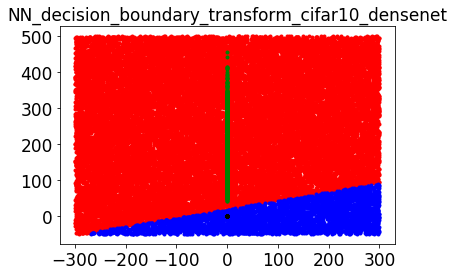

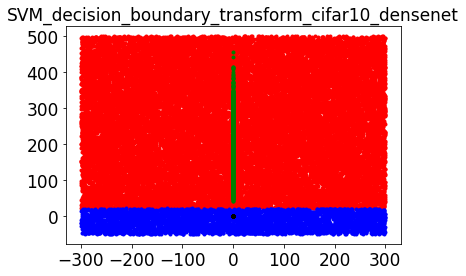

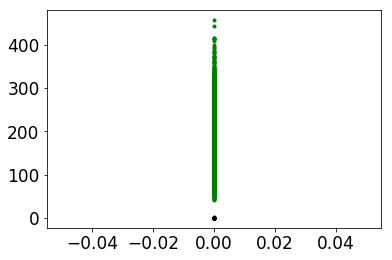

In [36]:
plot_temp(feature_t, label_t)

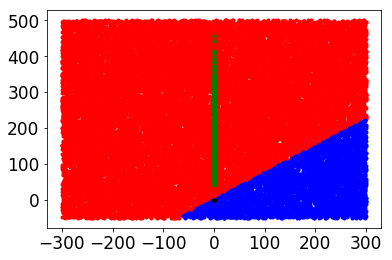

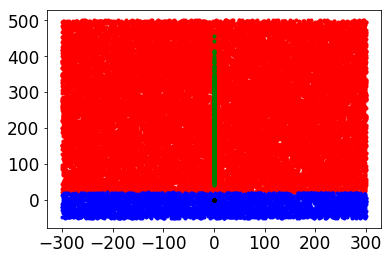

In [37]:
plot_temp_all(feature_random, pre_label_nn,feature_t, label_t)
plot_temp_all(feature_random, pre_label_svm,feature_t, label_t)

In [30]:
	plot_blobs_all_together(feature_random, pre_label_nn,feature_t, label_t,
		'../result/exploration/NN_decision_boundary_transform_cifar10_densenet.png')
	plot_blobs_all_together(feature_random, pre_label_svm,feature_t, label_t,
		'../result/exploration/SVM_decision_boundary_transform_cifar10_densenet.png')